## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [14]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [15]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

In [16]:
df.head().T

,0,1,2,3,4
neighbourhood_group,Brooklyn,Manhattan,Manhattan,Brooklyn,Manhattan
latitude,40.64749,40.75362,40.80902,40.68514,40.79851
longitude,-73.97237,-73.98377,-73.9419,-73.95976,-73.94399
room_type,Private room,Entire home/apt,Private room,Entire home/apt,Entire home/apt
price,149,225,150,89,80
minimum_nights,1,1,3,1,10
number_of_reviews,9,45,0,270,9
reviews_per_month,0.21,0.38,0.0,4.64,0.1
calculated_host_listings_count,6,2,1,1,1
availability_365,365,355,365,194,0


* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [17]:
df.price = np.log1p(df.price)

from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

y_train = df_train['price']
y_val = df_val['price']
y_test = df_test['price']

del df_train ['price']
del df_val ['price']
del df_test ['price']

In [18]:
df_train.head()

,neighbourhood_group,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Queens,40.76434,-73.92132,Entire home/apt,4,30,0.32,1,363
1,Brooklyn,40.73442,-73.95854,Private room,5,2,0.16,1,0
2,Brooklyn,40.66359,-73.99487,Entire home/apt,1,33,2.75,5,113
3,Brooklyn,40.63766,-74.02626,Private room,3,1,0.12,2,362
4,Brooklyn,40.65118,-74.00842,Private room,2,0,0.00,2,365


In [19]:

df.isnull().sum()

neighbourhood_group               0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

Now, use `DictVectorizer` to turn train and validation into matrices:

In [21]:
from sklearn.feature_extraction import DictVectorizer

train_dict = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient = 'records')
X_val = dv.fit_transform(val_dict)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [22]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text


dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf= RandomForestRegressor(n_estimators=10,
                          random_state=1,
                          n_jobs=-1)

rf.fit(X_train,y_train)

y_pred = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

In [24]:
rmse

0.4615632303514057

What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [25]:
scores = []
 
for n in range (10, 201, 10):
    rf= RandomForestRegressor(n_estimators= n, random_state=1,n_jobs=-1)
    rf.fit(X_train,y_train)
    
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append((n,rmse))

df_scores = pd.DataFrame(scores, columns = ['n_est', 'rmse'])
df_scores 

,n_est,rmse
0,10,0.461563
1,20,0.448184
2,30,0.445535
3,40,0.443637
4,50,0.442325
5,60,0.441639
6,70,0.441240
7,80,0.441125
8,90,0.440551
9,100,0.439973


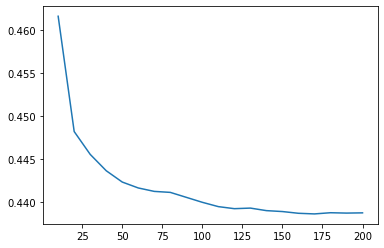

In [26]:
plt.plot(df_scores.n_est, df_scores.rmse)

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [47]:
scores = []

for d in [10, 15, 20, 25]:
    for n in range (10, 201, 10):
        rf= RandomForestRegressor(n_estimators= n, max_depth = d, random_state=3,n_jobs=-1)
        rf.fit(X_train,y_train)

        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        scores.append((n,rmse,d))

df_scores_d = pd.DataFrame(scores, columns = ['n_est', 'rmse', 'mdepth'])
df_scores_d

,n_est,rmse,mdepth
0,10,0.444286,10
1,20,0.441130,10
2,30,0.440632,10
3,40,0.439913,10
4,50,0.439827,10
...,...,...,...
75,160,0.438914,25
76,170,0.438749,25
77,180,0.438700,25
78,190,0.438637,25


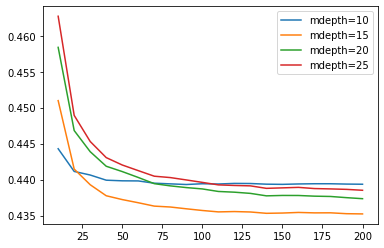

In [48]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores_d[df_scores_d.mdepth == d]
    plt.plot(df_subset.n_est, df_subset.rmse, label = 'mdepth=%d' % d)

plt.legend()

What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

Yes the answer would be the same.

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [49]:
rf= RandomForestRegressor(n_estimators= 10, max_depth = 20, random_state=1,n_jobs=-1)

rf.fit(X_train,y_train)


RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

<AxesSubplot:>

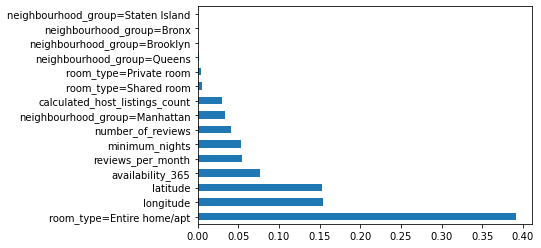

In [58]:


feat_importances = pd.Series(rf.feature_importances_, index=dv.get_feature_names())
feat_importances.nlargest(15).plot(kind='barh')

What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [3]:
!pip install xgboost

  Using cached xgboost-1.5.0-py3-none-win_amd64.whl (106.6 MB)


In [27]:
import xgboost as xgb

In [28]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [29]:
watch_list = [(dtrain, 'train'), (dval, 'val')]


In [30]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

In [31]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100)
y_pred = model.predict(dval)

In [32]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse

0.43621034591295677

Now change `eta` first to `0.1` and then to `0.01`

In [33]:
scores= []
for eta in [0.1, 0.3, 0.01]:
  xgb_params = {
      'eta': eta, 
      'max_depth': 6,
      'min_child_weight': 1,

      'objective': 'reg:squarederror',
      'nthread': 8,

      'seed': 1,
      'verbosity': 1,
  }
    
  model = xgb.train(xgb_params, dtrain, num_boost_round=100)
  y_pred = model.predict(dval)
  rmse = np.sqrt(mean_squared_error(y_val, y_pred))
  
  scores.append((eta,rmse))
  print(f"for eta={eta} rmse= {rmse}")

for eta=0.1 rmse= 0.43249655247991464
for eta=0.3 rmse= 0.43621034591295677
for eta=0.01 rmse= 1.630452438951798


What's the best eta?

* 0.3
* 0.1
* 0.01

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

